<a href="https://colab.research.google.com/github/androbaza/IP-algos/blob/main/2_Frequency_Domain_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time, math
from imageio import imread
import matplotlib.pyplot as plt

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import convolve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(512, 512)


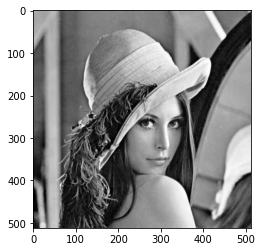

In [3]:
im = imread("/content/drive/MyDrive/samples/lena.jpg", pilmode="L")
plt.imshow(im, cmap="gray")
print(im.shape)
plt.show()

# Exercise 4: Filtering in Frequency Domain

The discrete Fourier transform (DFT) represents an image as a sum of sine and cosine waves with different frequencies and amplitudes. It is defined as:

$$
F(u,v) = \sum_{x=0}^{M}\sum_{y=0}^{N}f(x,y) \cdot e^{-2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)} \;.
$$

This equation makes use of [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula) to represent the base function of the transform:

$$
e^{i \cdot x} = \mathrm{cos}(x) + i\cdot \mathrm{sin}(x) \;.
$$

The result is an array of complex numbers $F(u,v)$, each encoding the parameters of a wave with horizontal frequency $u$ and vertical frequency $v$. The absolute value of that number encodes the *amplitude* of that wave and its argument (the angle between the coefficients of the complex number) encodes the *phase* (offset) of the wave.

For a more extensive explanation, please refer to [this page](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm).

## Task 2 - Filtering in Frequency Domain

1. Implement a function that performs linear filtering in the frequency domain. The inputs of this function should be the **image** and the **filter mask** in the *spatial domain*!
2. Compare the results of your function with `scipy.ndimage.filters.convolve`, qualitatively and quantitavely (*MAP error*)!
3. Plot the runtimes of your function and compare them with the runtimes of `scipy.ndimage.filters.convolve` for different filter sizes!

In [4]:
def DFT(im, shift=False):
    
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    
    I = fft2(im) # TODO: perform descrete FFT
    
    if shift:
        I = fftshift(I)
        # TODO: shift spectrum
        pass
    
    return I

def iDFT(I, shift=False, norm=False):
    
    if shift:
        I = ifftshift(I)
        # TODO: shift spectrum if wanted
        pass
    
    im = ifft2(I) # TODO: perform descrete inverse FFT
    
    if norm:
        im = (im.astype(np.float32) - im.min()) / (im.max() - im.min())
    
    return im

In [15]:
def imfilter_FFT(im, mask):
    
# manual padding makes the image divided in misplaced tiles. did not understand the cause.

    # h, w = im.shape
    # f_h, f_w = mask.shape
    # d_h, d_w = h - f_h, w - f_w
    

    # padding =[
    #     (int(d_h/2), int(math.ceil(d_h/2))
    #     ), (int(d_w/2), int(math.ceil(d_w/2))
    #     )
    # ]     
    # padded_mask = np.pad(mask, padding, mode="constant")
    # fourier = DFT(im, shift=True) * DFT(padded_mask, shift=True) 
    # res = np.abs(iDFT(fourier, shift=True))

    # using inbuilt padding
    return np.abs(ifft2(fft2(im) * fft2(mask, shape=im.shape)))

In [5]:
def box_filter(size):
    return np.ones((size, size)) / size**2

CPU times: user 48.3 ms, sys: 0 ns, total: 48.3 ms
Wall time: 54.2 ms
CPU times: user 41.7 ms, sys: 754 µs, total: 42.4 ms
Wall time: 65.6 ms
2.4858932495117188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in floor_divide
  if __name__ == '__main__':


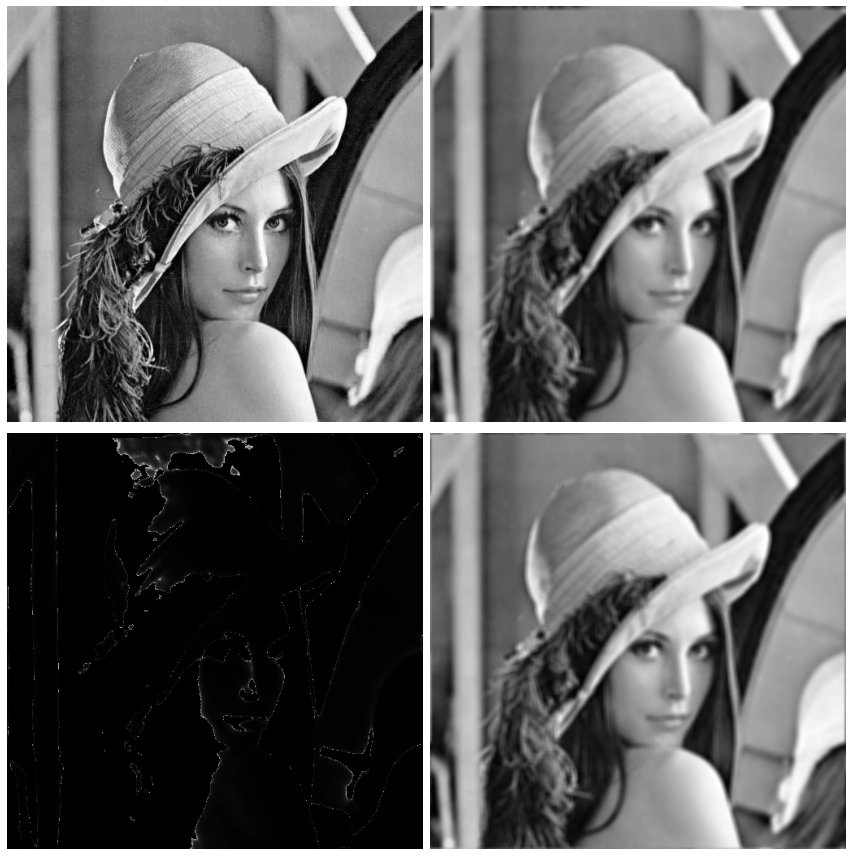

In [21]:
size = 7
B = box_filter(size)

_im = im.copy()

%time im0 = (imfilter_FFT(_im, B)).astype(np.uint8)
%time im1 = convolve(_im, B, mode="wrap")

diff = im0//(im0+im1) # TODO: compute MAP of im0 and im1
print(diff.mean())

fig, axs = plt.subplots(2,2, figsize=(12, 12))

axs[0,0].imshow(_im, cmap=plt.cm.gray)
axs[1,0].imshow(diff, cmap=plt.cm.gray)
axs[0,1].imshow(im0, cmap=plt.cm.gray)
axs[1,1].imshow(im1, cmap=plt.cm.gray)
# TODO: visualize _im
# TODO: visualize diff 
# TODO: visualize im0
# TODO: visualize im1

for ax in axs.ravel():
    ax.axis('off')
fig.tight_layout()
plt.show()

In [23]:
mm = %timeit im1 = convolve(_im, B, mode="wrap")

10 loops, best of 5: 40.8 ms per loop


In [27]:


start = time.time()
print("hello")
end = time.time()
print(end)

hello
1654264837.8448415


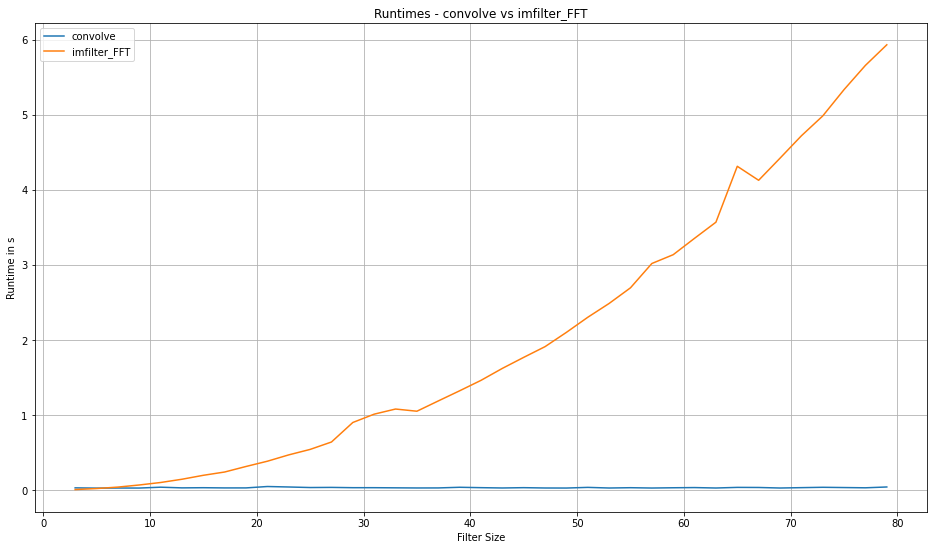

In [31]:
import time

def plot_runtimes(im, sizes, func1, func2):
    xs = sizes
    ys_f1 = []
    ys_f2 = []
    
    for size in sizes:
        B = box_filter(size)

        start = time.time()
        im0 = (imfilter_FFT(_im, B)).astype(np.uint8)
        end = time.time()
        
        ys_f1.append(end-start)

        start = time.time()
        im1 = convolve(_im, B, mode="wrap")
        end = time.time()

        ys_f2.append(end-start)
        
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    ax.set_title(f"Runtimes - {func1.__name__} vs {func2.__name__}")
    ax.set_xlabel("Filter Size")
    ax.set_ylabel("Runtime in s")
    
    ax.plot(xs, ys_f1, label=f"{func1.__name__}")
    ax.plot(xs, ys_f2, label=f"{func2.__name__}")
    
    ax.legend()
    ax.grid()
    
    plt.show()
    plt.close()

sizes = np.arange(3, 80, step=2)
plot_runtimes(im, sizes, convolve, imfilter_FFT)

filtering in Fourier space has shown to be faster for the 7x7 filter size, but then the performance starts dropping when compared to convolution (probably due to the convolution's implementations has SVD implemented for larger filter sizes)